In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

datasetJSONPath = os.getcwd() + "/datasets/covenant_wmi_remote_event_subscription_ActiveScriptEventConsumers_2020-09-01214330.json"
df = json.read_json(path_or_buf=datasetJSONPath, lines=True)

df.shape

2023-04-22 16:56:50.304842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 16:57:15.466754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/software/uoa/spack-sw/linux-rhel8-x86_64/gcc-12.1.0/anaconda3-2021.05-g6kymc6js7tc3estviv2s7j4dqo7cant/lib:/opt/slurm/22.05.2-1/lib
2023-04-22 16:57:15.469118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD

(3719, 176)

In [2]:
# functions definition

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))            
    return df

# fit the dataframe and record the label encoders for each column
def labelEncoder_get(df):
    le_dict = {}
    for column in df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column])
        le_dict[column] = le
    return (df, le_dict)

# input the list of label encoders and transform the dataframe
def labelEncoder_trans(df, le_dict):
    for i, column in enumerate(df.columns):
        le = le_dict[column]
        df[column] = list(map(str, df[column]))
        df[column] = le.transform(df[column])
    return df

# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data
    

In [3]:
features = ["Channel", "EventID", "Message", "Image", "NewProcessName", "ImageLoaded", "LogonType", "ProcessName", "ProcessGuid", "ProcessId"]
df = df[features]

# change integers to strings to get a better performance in generating new data
df = int_to_str(df)
df.shape

(3719, 10)

## Replicate positive data

There are more negative data than positive data, and results from some analytics (e.g. analytics with merging) are less possible to be generated. So we replicate specific positive data to make CTGAN bias to them.

## Use CTGAN to generate new data

In [4]:
# from sdv.tabular import CTGAN

# # model = CTGAN(cuda=True)
# # model.fit(df)
# # save and reuse the model
# # model.save('RemoteWMIActiveScriptEventConsumers.pkl')

# model = CTGAN.load(r'models\RemoteWMIActiveScriptEventConsumers.pkl')

In [4]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(data=df)

# synthesizer = CTGANSynthesizer(metadata,cuda=True)

# synthesizer.fit(df)

# # save and reuse the model
# synthesizer.save(filepath=os.getcwd() + '/models/RemoteWMIActiveScriptEventConsumers.pkl')
synthesizer = CTGANSynthesizer.load(filepath=r'models/RemoteWMIActiveScriptEventConsumers.pkl')

In [5]:
new_data = synthesizer.sample(num_rows=1000000)
new_data.head()

,Channel,EventID,Message,Image,NewProcessName,ImageLoaded,LogonType,ProcessName,ProcessGuid,ProcessId
0,Security,4688,NaN,NaN,NaN,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,0x97c
1,Security,4658,A logon was attempted using explicit credentia...,NaN,NaN,NaN,NaN,C:\Users\pgustavo\Desktop\MoveWMI.exe,NaN,0x3cc
2,Microsoft-Windows-Sysmon/Operational,3,Registry object added or deleted:\r\nRuleName:...,C:\windows\system32\svchost.exe,NaN,NaN,NaN,NaN,{7ca9280a-4637-5f4e-e500-000000000400},4996
3,Microsoft-Windows-Sysmon/Operational,7,An attempt was made to duplicate a handle to a...,C:\Users\pgustavo\Desktop\MoveWMI.exe,NaN,NaN,NaN,NaN,{7ca9280a-448a-5f4e-2100-000000000400},940
4,Microsoft-Windows-Sysmon/Operational,11,Registry value set:\r\nRuleName: -\r\nEventTyp...,C:\Program Files\WindowsApps\microsoft.windows...,NaN,NaN,NaN,NaN,{7ca9280a-4637-5f4e-e500-000000000400},4996


In [ ]:
# # for debugging only
# count_items(preprocess_labelEncoder(df))
# count_items(preprocess_labelEncoder(new_data))

## Use hunter program on new data

In [6]:
# Analytic I
I = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '20')
    & (new_data['Message'].str.lower().str.contains('.*type: script.*', regex=True))
]
)
I

,Channel,EventID,Message,Image,NewProcessName,ImageLoaded,LogonType,ProcessName,ProcessGuid,ProcessId


In [7]:
# Analytic II
II  = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-WMI-Activity/Operational')
    & (new_data['EventID'] == '5861')
    & (new_data['Message'].str.lower().str.contains('.*scriptingengine = "vbscript".*', regex=True))
]
)
II

,Channel,EventID,Message,Image,NewProcessName,ImageLoaded,LogonType,ProcessName,ProcessGuid,ProcessId


In [25]:
# Analytic III
III = (
new_data[features]
    
[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '1')
    & (new_data['Image'].str.lower().str.contains('.*scrcons.*', regex=True))
]
)
len(III)

28

In [9]:
# Analytic IV
IV = (
new_data[features]
    
[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == '4688')
    & (new_data['NewProcessName'].str.lower().str.contains('.*scrcons.*', regex=True))
]
)
IV

,Channel,EventID,Message,Image,NewProcessName,ImageLoaded,LogonType,ProcessName,ProcessGuid,ProcessId
3578,Security,4688,A token right was adjusted.\r\n\r\nSubject:\r\...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,NaN,NaN,3256
4305,Security,4688,A token right was adjusted.\r\n\r\nSubject:\r\...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,NaN
4776,Security,4688,Image loaded:\r\nRuleName: -\r\nUtcTime: 2020-...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,0x97c
7353,Security,4688,Process accessed:\r\nRuleName: -\r\nUtcTime: 2...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,0x12c0
8178,Security,4688,A handle to an object was requested.\r\n\r\nSu...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,0x97c
...,...,...,...,...,...,...,...,...,...,...
989717,Security,4688,A token right was adjusted.\r\n\r\nSubject:\r\...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,0xb58
989942,Security,4688,A new process has been created.\r\n\r\nCreator...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,0x97c
997382,Security,4688,Process accessed:\r\nRuleName: -\r\nUtcTime: 2...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,0x97c
999566,Security,4688,Process accessed:\r\nRuleName: -\r\nUtcTime: 2...,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,NaN


In [10]:
# Analytic V
V = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (new_data['ImageLoaded'].str.lower().isin(['c:\\windows\\system32\\wbem\\scrcons.exe',
        'c:\\windows\\system32\\\vbscript.dll',
        'c:\\windows\\system32\\wbem\\\wbemdisp.dll',
        'c:\\windows\\system32\\wshom.ocx',
        'c:\\windows\\system32\\scrrun.dll'
    ]))
]
)
V

,Channel,EventID,Message,Image,NewProcessName,ImageLoaded,LogonType,ProcessName,ProcessGuid,ProcessId
1671,Microsoft-Windows-Sysmon/Operational,7,Process accessed:\r\nRuleName: -\r\nUtcTime: 2...,C:\Windows\System32\svchost.exe,NaN,C:\Windows\System32\scrrun.dll,NaN,NaN,{7ca9280a-4481-5f4e-0c00-000000000400},1444
19610,Microsoft-Windows-Sysmon/Operational,7,WmiEventConsumer activity detected:\r\nRuleNam...,C:\Windows\System32\svchost.exe,NaN,C:\Windows\System32\wshom.ocx,NaN,NaN,{ff90ade3-f8d5-5f4e-7a04-000000000400},6976
22769,Microsoft-Windows-Sysmon/Operational,7,Process accessed:\r\nRuleName: -\r\nUtcTime: 2...,C:\windows\Explorer.EXE,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,{c4e35f20-f8ea-5f4e-c504-000000000400},3192
26466,Microsoft-Windows-Sysmon/Operational,7,Registry object added or deleted:\r\nRuleName:...,NaN,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,{ff90ade3-f8ea-5f4e-7c04-000000000400},0x458
32940,Microsoft-Windows-Sysmon/Operational,7,Network connection detected:\r\nRuleName: -\r\...,C:\Windows\System32\svchost.exe,NaN,C:\Windows\System32\scrrun.dll,NaN,NaN,{c4e35f20-f8d5-5f4e-c404-000000000400},2920
...,...,...,...,...,...,...,...,...,...,...
984918,Microsoft-Windows-Sysmon/Operational,7,Image loaded:\r\nRuleName: -\r\nUtcTime: 2020-...,C:\Windows\System32\svchost.exe,NaN,C:\Windows\System32\wshom.ocx,NaN,NaN,{ff90ade3-459b-5f4e-1000-000000000400},3324
986989,Microsoft-Windows-Sysmon/Operational,7,The handle to an object was closed.\r\n\r\nSub...,C:\Users\pgustavo\Desktop\MoveWMI.exe,NaN,C:\Windows\System32\scrrun.dll,NaN,NaN,{ff90ade3-f8d5-5f4e-7a04-000000000400},972
989624,Microsoft-Windows-Sysmon/Operational,7,Registry object added or deleted:\r\nRuleName:...,C:\Windows\System32\svchost.exe,NaN,C:\Windows\System32\scrrun.dll,NaN,NaN,{ff90ade3-f8d5-5f4e-7a04-000000000400},5460
995152,Microsoft-Windows-Sysmon/Operational,7,An attempt was made to duplicate a handle to a...,System,NaN,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN,{ff90ade3-f8ea-5f4e-7b04-000000000400},972


In [20]:
# Analytic VI

# Join III & V
firstJoinDf = (
III[features]

[III['ProcessGuid'].isin(V['ProcessGuid'])]
)

networkConnectionDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '3')
]
)

# # (
# # pd.merge(firstJoinDf, networkConnectionDf,
# #     on = 'ProcessGuid', how = 'inner')
# # )
VI = (
networkConnectionDf[features]
    
# [(networkConnectionDf['ProcessGuid'] == networkConnectionDf['ProcessGuid'])
#     &(networkConnectionDf['ProcessGuid'].isin(firstJoinDf))]
[(networkConnectionDf['ProcessGuid'].isin(firstJoinDf['ProcessGuid']))]
)
VI

,Channel,EventID,Message,Image,NewProcessName,ImageLoaded,LogonType,ProcessName,ProcessGuid,ProcessId
28,Microsoft-Windows-Sysmon/Operational,3,The Windows Filtering Platform has permitted a...,C:\windows\system32\DFSRs.exe,NaN,NaN,NaN,NaN,{c4e35f20-66c3-5f4e-9602-000000000400},3500
37,Microsoft-Windows-Sysmon/Operational,3,Process accessed:\r\nRuleName: -\r\nUtcTime: 2...,C:\windows\System32\svchost.exe,NaN,C:\Windows\System32\version.dll,NaN,NaN,{7ca9280a-4499-5f4e-5400-000000000400},0x1510
59,Microsoft-Windows-Sysmon/Operational,3,The handle to an object was closed.\r\n\r\nSub...,C:\windows\system32\svchost.exe,NaN,NaN,NaN,NaN,NaN,3184
91,Microsoft-Windows-Sysmon/Operational,3,Image loaded:\r\nRuleName: -\r\nUtcTime: 2020-...,System,NaN,C:\Windows\System32\TextInputFramework.dll,NaN,NaN,{ff90ade3-f8ea-5f4e-7c04-000000000400},3324
180,Microsoft-Windows-Sysmon/Operational,3,Image loaded:\r\nRuleName: -\r\nUtcTime: 2020-...,System,NaN,NaN,NaN,NaN,{7ca9280a-4499-5f4e-5400-000000000400},3448
...,...,...,...,...,...,...,...,...,...,...
999882,Microsoft-Windows-Sysmon/Operational,3,Registry object added or deleted:\r\nRuleName:...,C:\windows\Explorer.EXE,NaN,NaN,NaN,NaN,{c4e35f20-f8ea-5f4e-c504-000000000400},4800
999894,Microsoft-Windows-Sysmon/Operational,3,Registry value set:\r\nRuleName: -\r\nEventTyp...,C:\windows\system32\DFSRs.exe,NaN,C:\Windows\System32\combase.dll,NaN,NaN,{c4e35f20-f8ea-5f4e-c504-000000000400},1444
999905,Microsoft-Windows-Sysmon/Operational,3,RawAccessRead detected:\r\nRuleName: -\r\nUtcT...,C:\windows\system32\svchost.exe,NaN,C:\Windows\System32\vcruntime140_clr0400.dll,NaN,NaN,NaN,3324
999906,Microsoft-Windows-Sysmon/Operational,3,File Delete:\r\nRuleName: -\r\nUtcTime: 2020-0...,NaN,NaN,NaN,NaN,NaN,NaN,3184


In [38]:
# Analytic VII
# firstJoinDf['ProcessId'] = firstJoinDf['ProcessId'].apply(int).apply(hex)

networkLogonDf = (
new_data[features]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == '4624')
    & (new_data['LogonType'] == 3.0) #
]
)

# (
# pd.merge(firstJoinDf, networkLogonDf,
#     on = 'ProcessId', how = 'inner')
# )

VII = (
networkLogonDf[features]

[networkLogonDf['ProcessId'].isin(firstJoinDf['ProcessId'])]
)
len(VII)

21

In [31]:
# Analytic VIII
VIII = (
new_data[features]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == '4624')
    & (new_data['LogonType'] == 3.0)
    & (new_data['ProcessName'].str.lower().str.endswith('scrcons.exe', na=False))
]
)
VIII

,Channel,EventID,Message,Image,NewProcessName,ImageLoaded,LogonType,ProcessName,ProcessGuid,ProcessId
71536,Security,4624,Registry value set:\r\nRuleName: -\r\nEventTyp...,NaN,NaN,NaN,3.0,C:\Windows\System32\wbem\scrcons.exe,NaN,NaN
304686,Security,4624,A process has exited.\r\n\r\nSubject:\r\n\tSec...,NaN,NaN,NaN,3.0,C:\Windows\System32\wbem\scrcons.exe,NaN,0x1510
531233,Security,4624,Pipe Connected:\r\nRuleName: -\r\nEventType: C...,NaN,NaN,NaN,3.0,C:\Windows\System32\wbem\scrcons.exe,NaN,0x2e0


### Generate data
Randomly pick data from each analytic's results, and combine them as the generated dataset.

In [39]:
# randomly pick from results of analytics
results = [III, IV, V, VI, VII, VIII]
# not pick from II because original data doesn't have result from it
pick_nums = [28, 695, 154, 1000, 21, 3] # 6000
gen_data = random_generator(results, pick_nums)

gen_data.shape

(1901, 10)

## Decision Tree

### Preprocess data

In [28]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

### Original data

Balanced accuracy score: 0.50


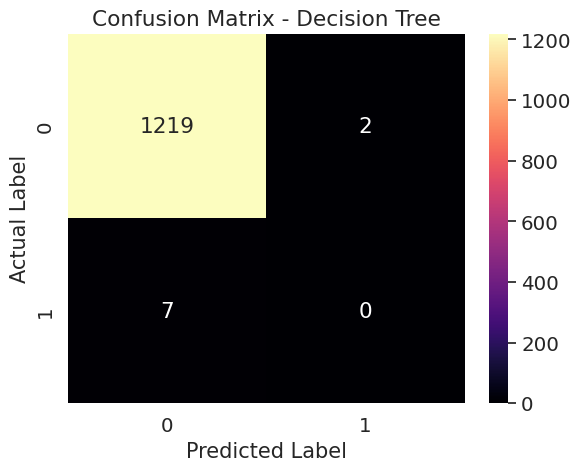

<Figure size 1000x700 with 0 Axes>

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1221
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1228
   macro avg       0.50      0.50      0.50      1228
weighted avg       0.99      0.99      0.99      1228



In [40]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

X = preprocess(df)
X, le_dict = labelEncoder_get(X)
y = labelList(df.shape[0], [157, 3307, 156, 1532, 1744, 1537, 1591, 1600, 2151, 1799])
clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

### Original data with generated data
Generated data should only be added into trianing set.

Balanced accuracy score: 0.78


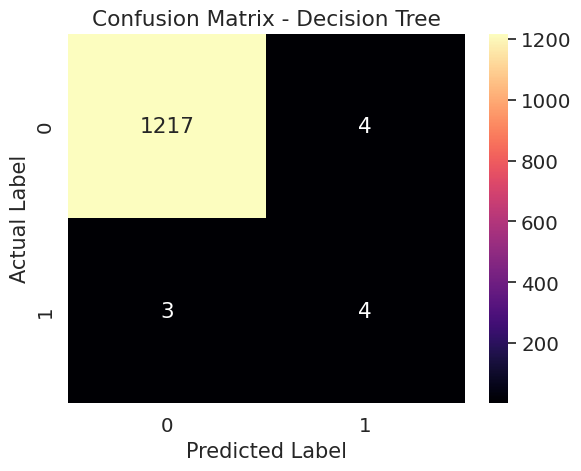

<Figure size 1000x700 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1221
           1       0.50      0.57      0.53         7

    accuracy                           0.99      1228
   macro avg       0.75      0.78      0.77      1228
weighted avg       0.99      0.99      0.99      1228



In [41]:
X_gen = preprocess(gen_data)
X_gen = labelEncoder_trans(X_gen, le_dict)
# add generated data to the original training set
X_train_new = pd.concat([X_train, X_gen], axis=0)

# generated data are all positive
for i in range(len(gen_data)):
    y_train.append(1)

clf = DecisionTreeClassifier()

clf.fit(X_train_new, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

## Save generated data

In [43]:
# # extract to JSON file
# dataset.reset_index(drop=True, inplace=True)
gen_data.to_json(r'generated_datasets/covenant_wmi_remote_event_subscription_ActiveScriptEventConsumers_new.json', orient='records')

# dataset = json.read_json(path_or_buf=os.getcwd()+ "\\generated_datasets"+ "\\empire_dllinjection_LoadLibrary_CreateRemoteThread_new.json")
# dataset.head()